# Example of doing constrained conformer generation
## And an example of where if goes wrong

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS

In [2]:
# This is the function that defines the tethered atoms and does the constraind embedding
# I don't fully understand what's going on with the ReplaceSidechains, DeleteSubstructs and UpdatePropertyCache
# methods. This is just code I found that on the internet seems to (mostly) work!
#
# For more information see http://rdkit.blogspot.com/2013/12/using-allchemconstrainedembed.html

def tether_mol_v1(tether, mol):
    mcs = rdFMCS.FindMCS([tether, mol], completeRingsOnly=True, matchValences=True)
    print('smarts:', mcs.smartsString)
    replaced = AllChem.ReplaceSidechains(tether, mcs.queryMol)
    core = AllChem.DeleteSubstructs(replaced, Chem.MolFromSmiles('*'))
    core.UpdatePropertyCache()
    molh = Chem.AddHs(ligand)
    AllChem.ConstrainedEmbed(molh, core)
    return molh

In [7]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

CS(=O)(=O)NCCc1ccccc1


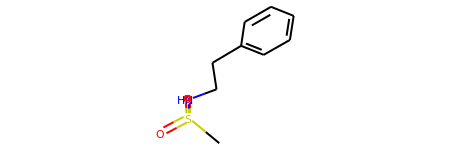

In [3]:
# read the molecule to use as the tether
tether = Chem.MolFromMolFile('data/misc/Mpro-x0072.mol')
print(Chem.MolToSmiles(tether))
tether

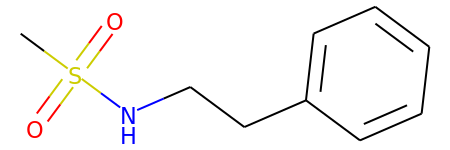

In [4]:
# here it is in 2D which is clearer 
t = Chem.MolFromSmiles('CS(=O)(=O)NCCc1ccccc1')
t

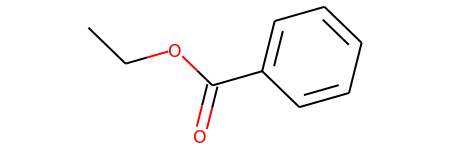

In [5]:
# this is an example where it works
ligand = Chem.MolFromSmiles('CCOC(=O)c1ccccc1')
ligand

smarts: [#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1


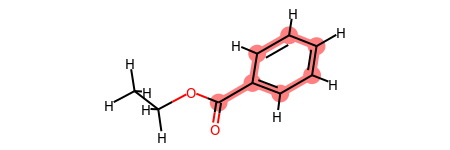

In [6]:
# the MCS is toluene which is correct. Those atoms get fixed.
# Nice that RDKit automatically highlights the MCS!
mol = tether_mol_v1(tether, ligand)
mol

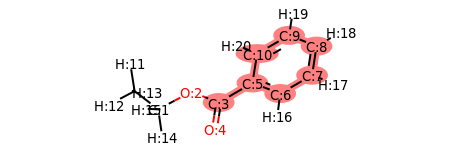

In [8]:
mol_with_atom_index(mol)

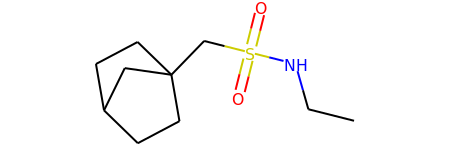

In [11]:
# And now an example where it goes wrong. The MCS should be based around the sulphonamide
ligand = Chem.MolFromSmiles('CCNS(=O)(=O)CC12CCC(CC1)C2')
ligand

In [12]:
# but clearly the MCS is not correct and the constrained embedding goes horribly wrong.
mol = tether_mol_v1(tether, ligand)
mol

smarts: [#6]-&!@[#6]1:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@[#6]:,-;@1


AttributeError: 'MCSResult' object has no attribute 'queryMol'

In [13]:
# the problem was how the bonds were being compared.
# If we use the bondCompare=rdFMCS.BondCompare.CompareOrderExact then the bonds must
# match exactly and things work as expected. Without this (bondCompare=CompareOrder is the default)
# aromatic and aliphatic rings match which results in the strange cage-like ring structure on the left 
# matching and giving a bigger MCS that the sulphonamide group.

def tether_mol_v2(tether, mol):
    mcs = rdFMCS.FindMCS([tether, mol], completeRingsOnly=True, matchValences=True,
                                         bondCompare=rdFMCS.BondCompare.CompareOrderExact)
    print('smarts:', mcs.smartsString)

    # Creating core of reference ligand #
    smarts = Chem.MolFromSmarts(mcs.smartsString)
    replaced = AllChem.ReplaceSidechains(tether, smarts)
    core = AllChem.DeleteSubstructs(replaced, Chem.MolFromSmiles('*'))
    core.UpdatePropertyCache()
    molh = Chem.AddHs(ligand)
    AllChem.ConstrainedEmbed(molh, core)
    return molh

smarts: [#16](-&!@[#6])(=&!@[#8])(=&!@[#8])-&!@[#7]-&!@[#6]-&!@[#6]


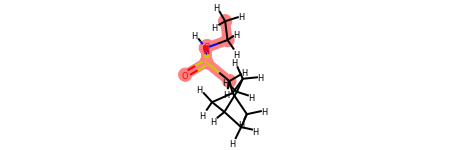

In [14]:
# Now we have the MCS we expect
mol = tether_mol_v2(tether, ligand)
mol